# COMP3359 Project
## Group 28: Classification of Tropical Cyclone Satellite Image by Intensity
## Demostration

This notebook serves for using a trained model to perform prediction of a tropical cyclone satellite image.

#### Requirement of the input's image
1. The size of it must be least 256px x 256px
2. It can be in RGB/Greyscale
3. It is readable by python PIL package

In [2]:
"""Install pytorch according to your CUDA version"""
# Uncomment % ... to see your CUDA version, if you are using Linux
# !/usr/local/cuda/bin/nvcc --version

# If you are using CUDA 10.0 (HKU GPU Phrase 1)
# !pip install Pillow==6.1
# !pip install torch===1.2.0 torchvision===0.4.0 -f https://download.pytorch.org/whl/torch_stable.html

# If you have CUDA 10.1 (HKU GPU Phrase 2)
# !pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# If you have CUDA 10.2
# !pip install pytorch torchvision

# If you don't have any supported GPU
# !pip install torch==1.5.0+cpu torchvision==0.6.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

In [136]:
# Install required packages that is not included in Conda
# !pip install torchsummary efficientnet_pytorch
# If you are not using conda then install these as well
# !pip install matplotlib Pillow

  Created wheel for flashtorch: filename=flashtorch-0.1.2-py3-none-any.whl size=26234 sha256=96768b7374d0c80017f5c248eab15adb18de2eb45f430994558d130a1423cf56
  Stored in directory: /userhome/30/cyleung2/.cache/pip/wheels/74/0c/41/36dc9875403c7f8025cc8d2c3a937af14b5ccb9ea9c247726b
Successfully built flashtorch


In [161]:
# Import all required Stuff
import requests
from io import BytesIO

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet
from torchsummary import summary
from torchvision import transforms
from PIL import Image

%matplotlib inline

In [162]:
# The final model of this project
class EffNet(nn.Module):
    def __init__(self):
        super(EffNet, self).__init__()

        self.conv = EfficientNet.from_pretrained('efficientnet-b3')
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(1536, 768),
            nn.Dropout(0.35),
            nn.ELU(inplace=True),
            nn.Linear(768,6)
        )

    def forward(self, x):
        x = self.conv.extract_features(x)
        x = self.fc(x)
        return x

In [163]:
# Check the running computer have supported GPU or not
GPU_aval = torch.cuda.is_available()
device = torch.device('cuda') if GPU_aval else torch.device('cpu')
print(device)

cuda


In [164]:
# Load the trained model parameters
model_path = './effnet3/model_best.pth.tar'
if GPU_aval:
    state_dict = torch.load(model_path)['state_dict']
else:
    state_dict = torch.load(model_path, map_location=device)['state_dict']
model = EffNet()
model.load_state_dict(state_dict)
model.to(device)
summary(model, (3, 224, 224))

Loaded pretrained weights for efficientnet-b3
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 40, 112, 112]           1,080
       BatchNorm2d-3         [-1, 40, 112, 112]              80
MemoryEfficientSwish-4         [-1, 40, 112, 112]               0
         ZeroPad2d-5         [-1, 40, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 40, 112, 112]             360
       BatchNorm2d-7         [-1, 40, 112, 112]              80
MemoryEfficientSwish-8         [-1, 40, 112, 112]               0
          Identity-9             [-1, 40, 1, 1]               0
Conv2dStaticSamePadding-10             [-1, 10, 1, 1]             410
MemoryEfficientSwish-11             [-1, 10, 1, 1]               0
         Identity-12             [-1, 10, 1, 1]               0
Conv2dStaticSamePadding-13        

In [179]:
def download_img(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    return img

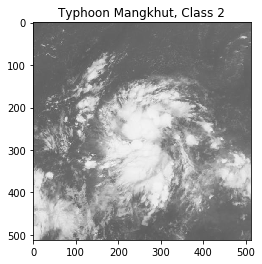

In [180]:
"""
    First, we need an typhoon for testing.
    As a Hong Konger, lets use the most significant typhoon in recent Hong Kong history:
    Typhoon Mangkhut(山竹). We are going to use digital typhoon as data source.
    Once again, Thanks Prof. Kitamoto for the amazing website and wonderful research
    
    Here we download a image of it.
    By the time of the image taken, it was just borned, so it was a class 2 typhoon
    
    Url for reference:
    Typhoon Mangkhut's detail:
    http://agora.ex.nii.ac.jp/digital-typhoon/summary/wnp/s/201822.html.en
    Image's detail:
    http://agora.ex.nii.ac.jp/cgi-bin/dt/single2.pl?prefix=HMW818090618&id=201822&basin=wnp&lang=en
"""
# Grab one image
img = download_img('http://agora.ex.nii.ac.jp/digital-typhoon/wnp/by-name/201822/1/512x512/HMW818090618.201822.jpg')
plt.title('Typhoon Mangkhut, Class 2')
imgplot = plt.imshow(img, cmap='gray')
plt.show()

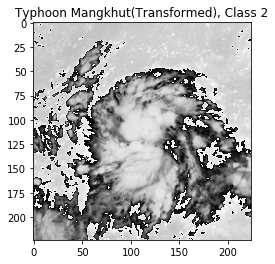

In [166]:
"""
    Next we need to pass to a transformer to make it works well with the model
    Here we use the transform that is idential to test set-up with to greyscale layer 
    for potential non-digital typhoon images
"""
default_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])])

def transform_to_tensor(img, transform=default_transform):
    return transform(img)

img_tensor = transform_to_tensor(img)
plt.title('Typhoon Mangkhut(Transformed), Class 2')
imgplot = plt.imshow(transforms.ToPILImage()(img_tensor), cmap='gray')
plt.show()

In [167]:
# Predict intensity class using the image
def predict(img_tensor, model):
    img_tensor = img_tensor.view(-1, 3, 224, 224) 
    img_tensor = img_tensor.to(device)
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        # Pass it to a sigmoid to get probabilities of each class
        output = torch.sigmoid(output)
        _, predict = torch.max(output.data, 1)
        predict_val = predict.item()
        conf = output[0][predict_val].item()

    return predict_val + 1, conf

predict(img_tensor, model)

(2, 0.8692430853843689)

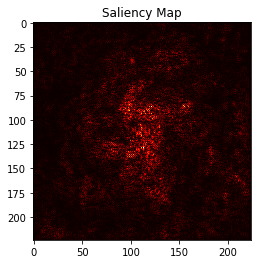

In [183]:
def get_saliency (img_tensor, model):
    img_tensor = img_tensor.view(-1, 3, 224, 224) 
    img_tensor = img_tensor.to(device)
    model.eval()
    img_tensor.requires_grad_()
    output = model(img_tensor)
    # Pass it to a sigmoid to get probabilities of each class
    output = torch.sigmoid(output)
    score_max_index = output.argmax()
    score_max = output[0,score_max_index]
    score_max.backward()
    saliency, _ = torch.max(img_tensor.grad.data.abs(),dim=1)
    saliency = saliency.cpu()
    plt.title('Saliency Map')
    plt.imshow(saliency[0], cmap=plt.cm.hot)
    plt.show()
get_saliency(img_tensor, model)

In [184]:
# Alternatively we can use this all in one function
def predict_img(img):
    img_tensor = transform_to_tensor(img)
    result, conf = predict(img_tensor, model)
    print(f"The predicted class is {result} with {conf * 100:.2f}% confidence.")
    get_saliency(img_tensor, model)

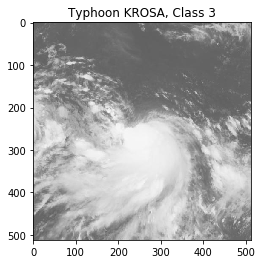

In [185]:
# Grab another image from another typhoon
img = download_img('http://agora.ex.nii.ac.jp/digital-typhoon/wnp/by-name/201910/1/512x512/HMW819080612.201910.jpg')
plt.title('Typhoon KROSA, Class 3')
imgplot = plt.imshow(img, cmap='gray')
plt.show()

#### Prediction function
With this function, we can easily predict a typhoon intensity just by passing an image.
Then, it will tell you the prediction result and the confidence rate.
As a bonus, it will also generate a saliency map that can tell you the model is looking at where part of the image.


The predicted class is 3 with 94.95% confidence.


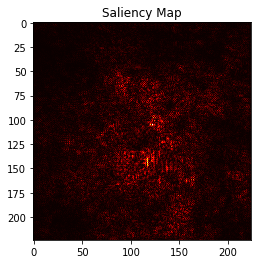

In [186]:
predict_img(img)